## Objective

#### NLP sentiment classification on news headlines
Using APIs or a little webscraping to harvest some new test data that you will manually label the new headlines as negative/positive and then see how your model does on those headlines.

#### Dataset:
[Sentiment Analysis for Financial News](https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news)

## Libraries

In [145]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# NLTK - Stopwords:
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from gensim.models.doc2vec import TaggedDocument
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

#to see the entire column width:
pd.set_option('display.max_colwidth', -1)

In [146]:
import tensorflow as tf
tf.__version__

'2.3.1'

### Imoport Data

In [147]:
df = pd.read_csv('all-data.csv', names = ['Sentiment', 'Headline'], 
                 encoding='latin-1')
df = df.sample(frac=1).reset_index(drop=True) # Shuffling the data in case there's an ordering bias
display(df.head())
print("Shape:", df.shape, "\n\n")
print(df.info())

Sentiment  \
0  neutral    
1  neutral    
2  positive   
3  positive   
4  positive   

                                                                                                                                                                                                                                                 Headline  
0  The building will house , for example , Respecta Oy 's Jyvaskyla premises , as well as other companies to be announced later , says Samuel Koivisto , Director of Technopolis operations in Jyvaskyla .                                                 
1  The business has sales of about ( Euro ) 35 million ( $ 44million ) , and has been responsible for sales and marketing of Lanxess 's paper chemicals business , which Kemira bought for ( Euro ) 88 million early this year ( CW , Jan. 11 , p. 22 ) .  
2  The diluted loss per share narrowed to EUR 0.27 from EUR 0.86 .                                                                                                                                                                                         
3  The parties have agreed to negotiate definitive distribution and license agreements by the end of June 2010 .                                                                                                                                           
4  Operating profit rose to EUR 1.6 mn from EUR 1.1 mn in the corresponding period in 2006 .

Shape: (4846, 2) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  4846 non-null   object
 1   Headline   4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB
None


In [148]:
# Look at the instances of each sentiment
df.Sentiment.value_counts()

neutral     2879
positive    1363
negative    604 
Name: Sentiment, dtype: int64

#### Visualize the data

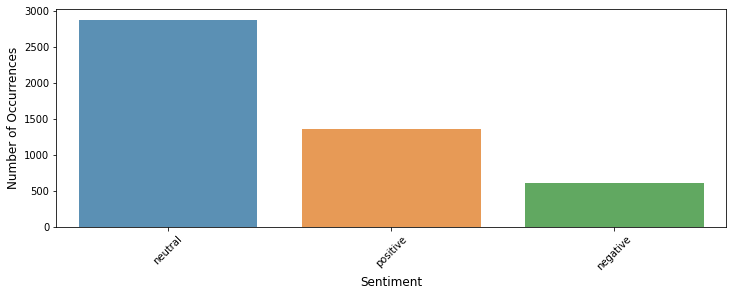

In [149]:
cnt_pro = df['Sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.xticks(rotation=45)
plt.show();

### Clean the Data

In [150]:
# Convert the string in the 'Sentiment' column to numeric form
Sentiment = {'positive': 0, 'neutral': 1, 'negative': 2} 

#df[Sentiment]=df[Sentiment].map(Sentiment)

In [151]:
# traversing through Sentiment column and writing values where key matches
df.Sentiment = [Sentiment[item] for item in df.Sentiment] 
df.head(10)

Sentiment  \
0  1           
1  1           
2  0           
3  0           
4  0           
5  0           
6  1           
7  1           
8  2           
9  1           

                                                                                                                                                                                                                                                 Headline  
0  The building will house , for example , Respecta Oy 's Jyvaskyla premises , as well as other companies to be announced later , says Samuel Koivisto , Director of Technopolis operations in Jyvaskyla .                                                 
1  The business has sales of about ( Euro ) 35 million ( $ 44million ) , and has been responsible for sales and marketing of Lanxess 's paper chemicals business , which Kemira bought for ( Euro ) 88 million early this year ( CW , Jan. 11 , p. 22 ) .  
2  The diluted loss per share narrowed to EUR 0.27 from EUR 0.86 .                                                                                                                                                                                         
3  The parties have agreed to negotiate definitive distribution and license agreements by the end of June 2010 .                                                                                                                                           
4  Operating profit rose to EUR 1.6 mn from EUR 1.1 mn in the corresponding period in 2006 .                                                                                                                                                               
5  The company is now intensifying its smelter operations and increasing its annual production capacity to 230,000 tonnes of copper .                                                                                                                      
6  Swedish engineering consultant firm Etteplan is to establish a unit in town Borl+Ænge , by the turn of the month March-April 2008 .                                                                                                                     
7  Shares will be acquired in accordance with section 5 of the rules of NASDAQ OMX Helsinki and other rules applicable to the acquisition of own shares .                                                                                                  
8  ADPnews - Aug 3 , 2009 - Finnish media group Ilkka-Yhtyma Oyj HEL : ILK2S said today its net profit fell 45 % on the year to EUR 5.9 million USD 8.4 m in the first half of 2009 .                                                                      
9  Finnish property investor Sponda said it has agreed a 100 mln eur , five-year mln credit facility with Swedbank and a 50 mln eur , seven-year facility with OKO Bank .

#### Stopwords:
Remove words from strings that have no unique information ('is','an','the).

In [152]:
#nltk.download('stopwords')

stop = set(stopwords.words('english'))
stop.add("'s")
for item in string.punctuation:
    stop.add (item)
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

df['Headline'] = df['Headline'].map(remove_stopwords)

In [153]:
#make a new column for clean headlines and then other columns for different version of data

In [154]:
#check
df.head()

Sentiment  \
0  1           
1  1           
2  0           
3  0           
4  0           

                                                                                                                                                          Headline  
0  building house example respecta oy jyvaskyla premises well companies announced later says samuel koivisto director technopolis operations jyvaskyla              
1  business sales euro 35 million 44million responsible sales marketing lanxess paper chemicals business kemira bought euro 88 million early year cw jan. 11 p. 22  
2  diluted loss per share narrowed eur 0.27 eur 0.86                                                                                                                
3  parties agreed negotiate definitive distribution license agreements end june 2010                                                                                
4  operating profit rose eur 1.6 mn eur 1.1 mn corresponding period 2006

#### Lemmatization:
Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. [Lemmatization](https://www.geeksforgeeks.org/python-lemmatization-with-nltk/)

In [155]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [156]:
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    text = [wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text.split()]
    return " ".join(text)

df['Headline_Lemma'] = df['Headline'].map(lemmatize)

In [157]:
#check
df.head()

Sentiment  \
0  1           
1  1           
2  0           
3  0           
4  0           

                                                                                                                                                          Headline  \
0  building house example respecta oy jyvaskyla premises well companies announced later says samuel koivisto director technopolis operations jyvaskyla               
1  business sales euro 35 million 44million responsible sales marketing lanxess paper chemicals business kemira bought euro 88 million early year cw jan. 11 p. 22   
2  diluted loss per share narrowed eur 0.27 eur 0.86                                                                                                                 
3  parties agreed negotiate definitive distribution license agreements end june 2010                                                                                 
4  operating profit rose eur 1.6 mn eur 1.1 mn corresponding period 2006                                                                                             

                                                                                                                                                 Headline_Lemma  
0  building house example respecta oy jyvaskyla premise well company announce later say samuel koivisto director technopolis operation jyvaskyla                 
1  business sale euro 35 million 44million responsible sale marketing lanxess paper chemical business kemira bought euro 88 million early year cw jan. 11 p. 22  
2  dilute loss per share narrow eur 0.27 eur 0.86                                                                                                                
3  party agree negotiate definitive distribution license agreement end june 2010                                                                                 
4  operating profit rise eur 1.6 mn eur 1.1 mn correspond period 2006

WordCloud to see the commonly used words

In [158]:
#!pip install wordcloud

In [159]:
# Separating out the categories
# pos = df.Headline[df.Sentiment[df.Sentiment== 1].index]
# neg = df.Headline[df.Sentiment[df.Sentiment== 0].index]

In [160]:
def wordcloud(dataset):
    plt.figure(figsize = (18,24)) # Text Reviews with positive Ratings
    wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1000, 
                          height = 600,
                          collocations=False).generate(" ".join(dataset))
    plt.imshow(wordcloud,interpolation = 'bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show();

def show_wordclouds(column='Headline'):
    # Separating out the categories
    pos = df[column][df.Sentiment[df.Sentiment== 1].index]
    neg = df[column][df.Sentiment[df.Sentiment== 0].index]
    print ('Positive Sentiment Wordcloud:')
    wordcloud(pos)
    
    print ('Negative Sentiment Wordcloud:')
    wordcloud(neg)
    

Positive Sentiment Wordcloud:


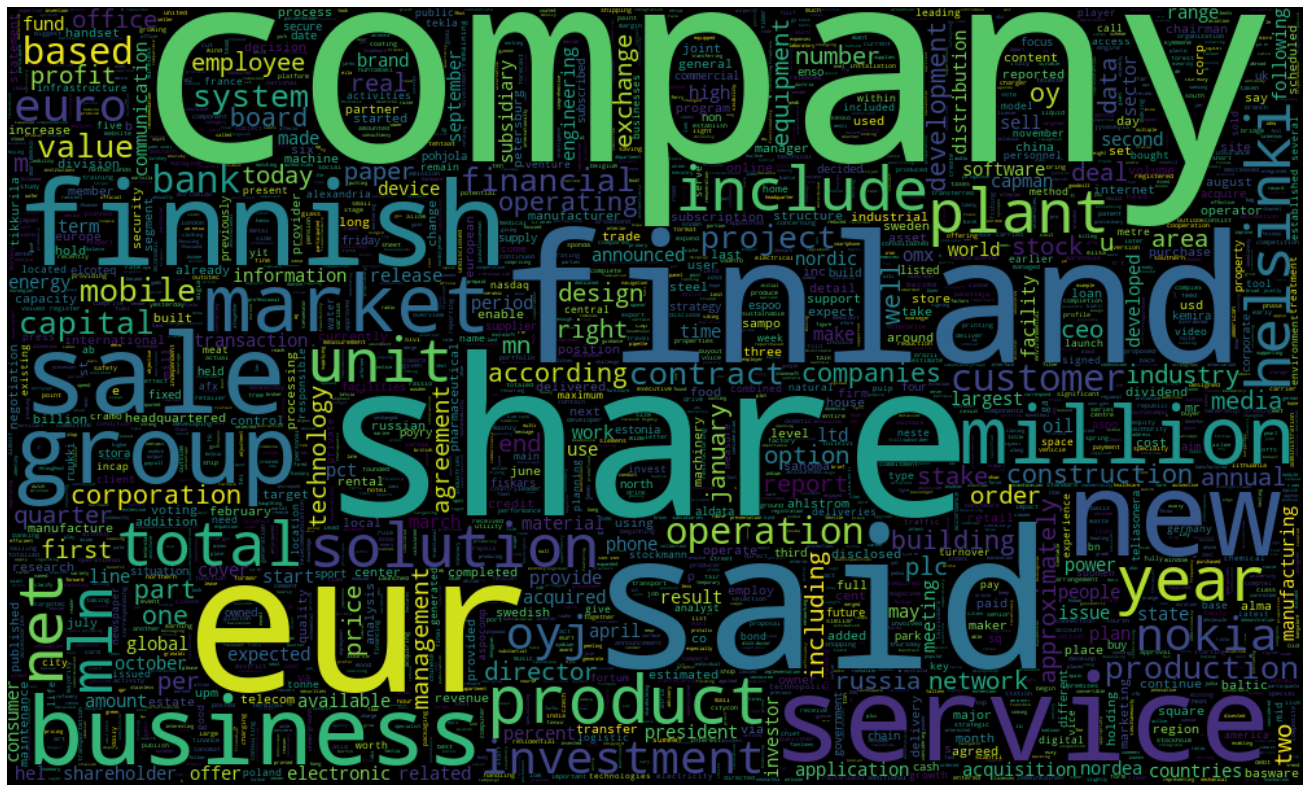

Negative Sentiment Wordcloud:


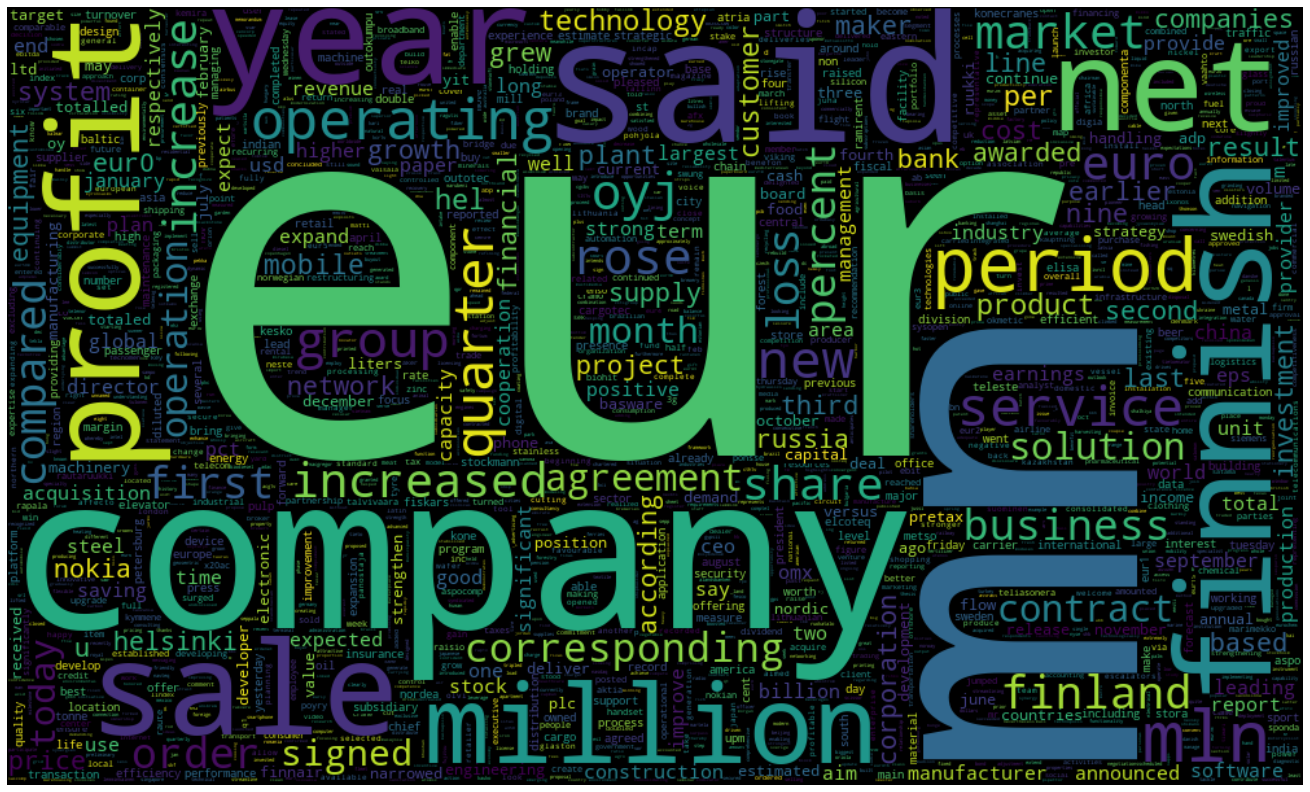

In [161]:
show_wordclouds()

Positive Sentiment Wordcloud:


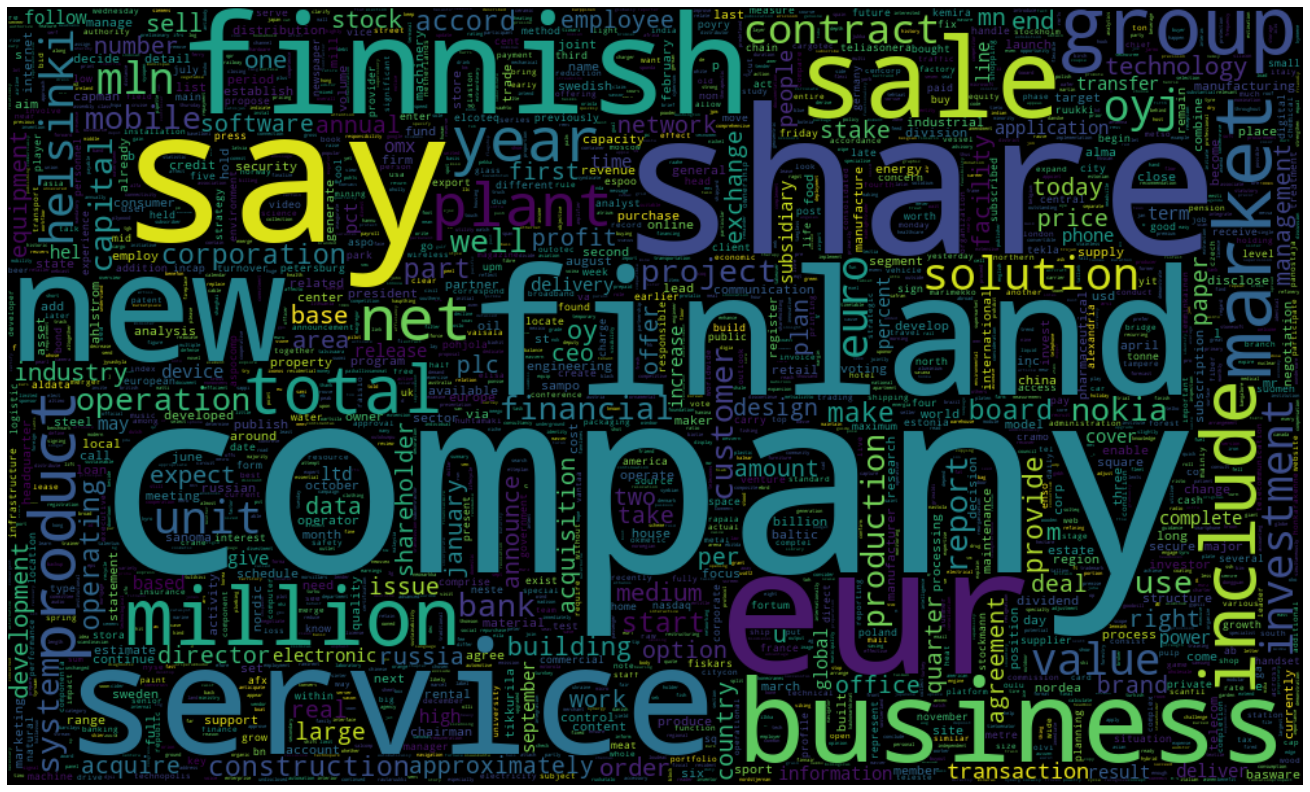

Negative Sentiment Wordcloud:


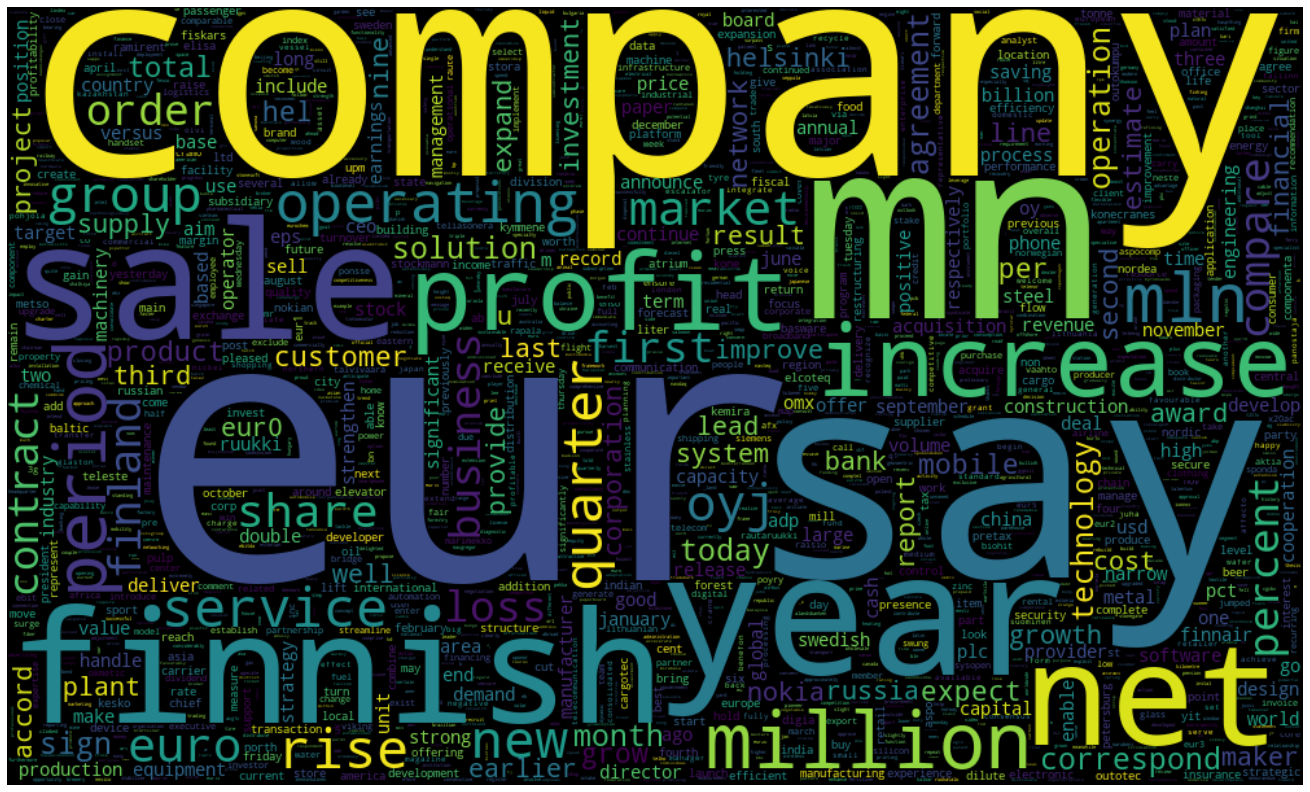

In [162]:
show_wordclouds('Headline_Lemma')

Process the text to convert text to lower-case strip punctuations and symbols etc.

In [163]:
from bs4 import BeautifulSoup
import re

def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text


df['Headline_soup'] = df['Headline_Lemma'].apply(cleanText)


In [164]:
df.head()

Sentiment  \
0  1           
1  1           
2  0           
3  0           
4  0           

                                                                                                                                                          Headline  \
0  building house example respecta oy jyvaskyla premises well companies announced later says samuel koivisto director technopolis operations jyvaskyla               
1  business sales euro 35 million 44million responsible sales marketing lanxess paper chemicals business kemira bought euro 88 million early year cw jan. 11 p. 22   
2  diluted loss per share narrowed eur 0.27 eur 0.86                                                                                                                 
3  parties agreed negotiate definitive distribution license agreements end june 2010                                                                                 
4  operating profit rose eur 1.6 mn eur 1.1 mn corresponding period 2006                                                                                             

                                                                                                                                                 Headline_Lemma  \
0  building house example respecta oy jyvaskyla premise well company announce later say samuel koivisto director technopolis operation jyvaskyla                  
1  business sale euro 35 million 44million responsible sale marketing lanxess paper chemical business kemira bought euro 88 million early year cw jan. 11 p. 22   
2  dilute loss per share narrow eur 0.27 eur 0.86                                                                                                                 
3  party agree negotiate definitive distribution license agreement end june 2010                                                                                  
4  operating profit rise eur 1.6 mn eur 1.1 mn correspond period 2006                                                                                             

                                                                                                                                                 Headline_soup  
0  building house eample respecta oy jyvaskyla premise well company announce later say samuel koivisto director technopolis operation jyvaskyla                 
1  business sale euro 35 million 44million responsible sale marketing laness paper chemical business kemira bought euro 88 million early year cw jan. 11 p. 22  
2  dilute loss per share narrow eur 0.27 eur 0.86                                                                                                               
3  party agree negotiate definitive distribution license agreement end june 2010                                                                                
4  operating profit rise eur 1.6 mn eur 1.1 mn correspond period 2006

#### Counter

In [165]:
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [166]:
text = df.Headline_Lemma
counter = counter_word(text)

In [167]:
len(counter)

10088

In [168]:
num_words = len(counter)

### Train/Test Split

In [169]:
# headlines = []
# labels = []

# for row in range(len(df)):
#     headlines.append(df['Headline_soup'][row])
#     labels.append(df['Sentiment'][row])

In [170]:
training_headlines, testing_headlines, training_labels, testing_labels = train_test_split(
    df['Headline_soup'], df['Sentiment'], test_size=0.2 , random_state=42)

In [171]:
# # Setting the training ratio
# training_size = int(df.shape[0] * .8) 

# # Train Test Split:
# # Already shuffled, so we're good to go
# training_headlines = headlines[0:training_size]
# testing_headlines = headlines[training_size:]
# training_labels = labels[0:training_size]
# testing_labels = labels[training_size:]

In [172]:
# Checking on a few of the headlines:
display(training_headlines[:3])
display(training_labels[:3])

432     acquisition part suomen helasto strategy epand lukkoepert security chain suomen helasto ceo kimmo uusimaki say                                                                          
3071    `` adjustment fall price level contrast less effective                                                                                                                                  
289     name applicant jot automation oyname inventor mammila tuomo piirainen mika kellokoski mikaapplication no. 2424-kolnp-2008 adate filing application 16-06-2008publication date 30/01/2009
Name: Headline_soup, dtype: object

432     1
3071    2
289     1
Name: Sentiment, dtype: int64

In [173]:
training_labels

432     1
3071    2
289     1
2588    1
4121    0
       ..
4426    1
466     0
3092    0
3772    0
860     2
Name: Sentiment, Length: 3876, dtype: int64

In [174]:
testing_labels

3207    1
1684    1
1044    0
4145    0
1538    1
       ..
3691    1
1507    1
1126    1
180     1
1215    0
Name: Sentiment, Length: 970, dtype: int64

### Tokenizer 
Tokenizing involoves splitting sentances and words from the body of the text
The use of a tokenizer creates a number coded to each word thereby allowing 
the neural network to build patterns and learn meaning.

In [175]:
# function to tokenize text

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens

In [176]:
# apply the splits to the tokenizer

# Gensim is a Python library for topic modeling, document indexing and Similarity retrieval with large corpora.
#[Gensim](https://pypi.org/project/gensim/)
# train_tagged = train.apply(
#     lambda r: TaggedDocument(words=tokenize_text(r['Headline']), tags=[r.Sentiment]), axis=1)
# test_tagged = test.apply(
#     lambda r: TaggedDocument(words=tokenize_text(r['Headline']), tags=[r.Sentiment]), axis=1)

In [177]:
# set the maximum words to be used
max_features = 500000

# set the maximum words in each headline
max_sequence_length = 50

tokenizer = Tokenizer(num_words=max_features, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(training_headlines)
X_train = tokenizer.texts_to_sequences(training_headlines)
training_padded = pad_sequences(X_train)
print('Found %s unique tokens.' % len(training_padded))


Found 3876 unique tokens.


In [178]:
# check the shape of data tensor:
X_test = tokenizer.texts_to_sequences(testing_headlines)
testing_padded = pad_sequences(X_test, maxlen=max_sequence_length)
print('Shape of data tensor:', testing_padded.shape)

Shape of data tensor: (970, 50)


In [179]:
embedding_dim = 32
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [180]:
# # Initializing the fitting the tokenizer:
# tokenizer = Tokenizer(num_words = num_words, oov_token = oov_tok)
# tokenizer.fit_on_texts(training_headlines)
# # Initializing the Word Index:
# word_index = tokenizer.word_index
# # Padding and Sequencing the Training Set:
# training_sequences = tokenizer.texts_to_sequences(training_headlines)
# training_padded = pad_sequences(training_sequences, maxlen = max_length,
#                                padding = padding_type, 
#                                truncating = trunc_type)
# # Padding and Sequencing the Testing Set:
# testing_sequences = tokenizer.texts_to_sequences(testing_headlines)
# testing_padded = pad_sequences(testing_sequences, maxlen = max_length, 
#                                padding = padding_type, 
#                                truncating = trunc_type)


In [181]:
# # Switch to Numpy Array
# # Necessary for the ANN to read the data
# training_padded = np.array(training_padded)
# training_labels = np.array(training_labels)
# testing_padded = np.array(testing_padded)
# testing_labels = np.array(testing_labels)

In [182]:
print ('Padded and Tokenized Headline:\n', training_padded[3])
print ('\nThe actual headline:\n', training_headlines[3])
print ('\nLabel:\n', training_labels[3])

Padded and Tokenized Headline:
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
 3753 3754 2085 1230 3755 2086 1765 2621 1766 3756 3757 2622  940]

The actual headline:
 party agree negotiate definitive distribution license agreement end june 2010

Label:
 0


In [183]:
# train
#train_tagged.values

In [184]:
from tensorflow.keras.utils import to_categorical
training_labels_ohe = to_categorical(training_labels)
testing_labels_ohe = to_categorical(testing_labels)

testing_labels_ohe[0]

array([0., 1., 0.], dtype=float32)

### Model 1 (Hidden Layer)

In [185]:
# embedding_dim = 100

# model = Sequential()
# model.add(Embedding(num_words, embedding_dim, input_length=64))
# model.add(Dense(200, activation='relu'))
# model.add(Dropout(0.2)) # Optional Regularization
# model.add(Dense(3, activation='sigmoid'))

# # Slower learning rate worked better as it kept the learning more stable
# #opt = keras.optimizers.Adam(lr=0.0001)
# model.compile(loss='categorical_crossentropy',optimizer='adam', 
#               metrics=['accuracy']) # Orig code

In [186]:
# num_epochs = 50
# # After 5 epochs of validation loss not improving, the model will stop.
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# history = model.fit(training_padded, training_labels, 
#                     epochs=num_epochs,
#                     batch_size = 10,
#                     validation_data=(testing_padded, testing_labels), 
#                     verbose= 1, callbacks=[es])

### Functions for Model Evaluation:

In [187]:
#results.history.keys()

In [188]:



def model_eval(history):
    pd.DataFrame(history.history).plot(figsize = (12,8)) 
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show
def plot_graphs(history, string):
    
#     history = results.history
#     plt.figure()
#     plt.plot(history['val_loss'])
#     plt.plot(history['loss'])
#     plt.legend(['val_loss', 'loss'])
#     plt.title('Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.show()
    
#     plt.figure()
#     plt.plot(history['val_accuracy'])
#     plt.plot(history['accuracy'])
#     plt.legend(['val_acc', 'acc'])
#     plt.title('Accuracy')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.show()
    
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

def model_metrics(model):
    train_acc = model.evaluate(training_padded, training_labels, verbose=0)
    test_acc = model.evaluate(testing_padded, testing_labels, verbose=0)
    print('Train Loss:', "{:.3%}".format(train_acc[0]))
    print('Train Accuracy:', "{:.3%}".format(train_acc[1]))
    print('Test Loss:', "{:.3%}".format(test_acc[0]))
    print('Test Accuracy:', "{:.3%}".format(test_acc[1]))
    
# Made up some easy headlines to see if the ANN works
def easy_headlines():
    sentence = ["stock rise rapid for tesla", 
                "apple factory shut down, lay off hundred employee",
                "average day of return for microsoft"]
    sequences = tokenizer.texts_to_sequences(sentence)
    padded = pad_sequences(sequences, maxlen=max_length, 
                           padding=padding_type, 
                           truncating=trunc_type)
    for headline in sentence:    
        print (headline)
    print(model.predict(padded))
    
# Random headlines from NYT Business  (post stopword removal and lemmatization) 
# This may be a bit trickier for the network
def harder_headlines():
    sentence = ["snowflake more  double  debut  wall street embrace tech ipos", 
                "europe economic revival imperil raising the specter grind downturn",
                "fed debate next step after shifting approach to rate setting"]
    sequences = tokenizer.texts_to_sequences(sentence)
    padded = pad_sequences(sequences, maxlen=max_length, 
                           padding=padding_type, 
                           truncating=trunc_type)
    for headline in sentence:    
        print (headline)
    print(model.predict(padded))

def test_headlines():
    print('Easier Headlines:')
    easy_headlines()
    print ('\n')
    print ('Realistic Headlines:')
    harder_headlines()

In [189]:
#model_metrics(model)

In [190]:
test_headlines()

Easier Headlines:
stock rise rapid for tesla
apple factory shut down, lay off hundred employee
average day of return for microsoft
[[0.33254877 0.32141826 0.346033  ]
 [0.33255145 0.32141742 0.34603104]
 [0.3325498  0.32141703 0.3460331 ]]


Realistic Headlines:
snowflake more  double  debut  wall street embrace tech ipos
europe economic revival imperil raising the specter grind downturn
fed debate next step after shifting approach to rate setting
[[0.33254904 0.32141754 0.34603345]
 [0.3325493  0.32141846 0.3460323 ]
 [0.3325491  0.3214183  0.3460326 ]]


### Model 2 (LSTM):

In [198]:
embedding_dim = 100

model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=max_length))
model.add(LSTM(64, dropout = 0.1, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy']) # Orig code

In [199]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 50, 100)           1008800   
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_23 (Dense)             (None, 3)                 99        
Total params: 1,053,219
Trainable params: 1,053,219
Non-trainable params: 0
_________________________________________________________________


In [200]:
num_epochs = 50
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(training_padded, training_labels_ohe, 
                    epochs=num_epochs,
                    batch_size = 24,
                    validation_data=(testing_padded, testing_labels_ohe), 
                    verbose= 1, callbacks = [es])

Epoch 1/50
162/162 [==============================] - 10s 62ms/step - loss: 0.8430 - accuracy: 0.6311 - val_loss: 0.7530 - val_accuracy: 0.6639
Epoch 2/50
162/162 [==============================] - 10s 61ms/step - loss: 0.5824 - accuracy: 0.7436 - val_loss: 0.7124 - val_accuracy: 0.7010
Epoch 3/50
162/162 [==============================] - 10s 60ms/step - loss: 0.3168 - accuracy: 0.8803 - val_loss: 0.8537 - val_accuracy: 0.7268
Epoch 4/50
162/162 [==============================] - 9s 58ms/step - loss: 0.1542 - accuracy: 0.9487 - val_loss: 0.9283 - val_accuracy: 0.7278
Epoch 5/50
162/162 [==============================] - 10s 59ms/step - loss: 0.0942 - accuracy: 0.9683 - val_loss: 1.2631 - val_accuracy: 0.7278
Epoch 6/50
162/162 [==============================] - 10s 61ms/step - loss: 0.0689 - accuracy: 0.9768 - val_loss: 1.2282 - val_accuracy: 0.7144
Epoch 7/50
162/162 [==============================] - 10s 60ms/step - loss: 0.0510 - accuracy: 0.9843 - val_loss: 1.4506 - val_accuracy: 

In [201]:
model_metrics(model)

ValueError: in user code:

    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1224 test_function  *
        return step_function(self, iterator)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1208 run_step  **
        outputs = model.test_step(data)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1177 test_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 3) are incompatible


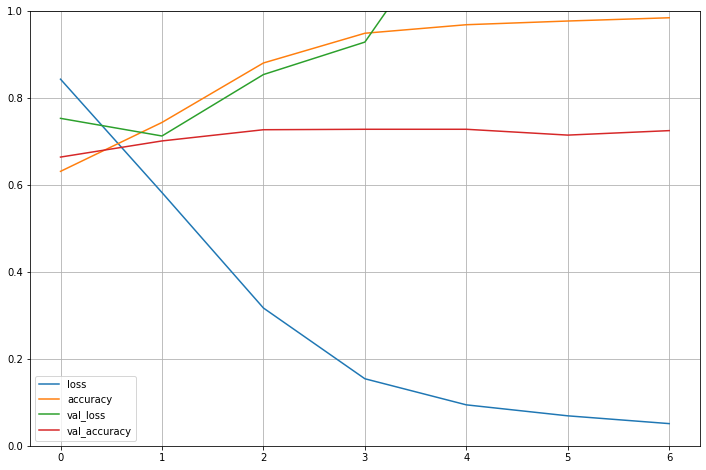

In [202]:
model_eval(history)

In [ ]:
embedding_dim = 32

model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=max_length))
model.add(LSTM(64, dropout = 0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy']) # Orig code

In [ ]:
num_epochs = 50
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(training_padded, training_labels_ohe, 
                    epochs=num_epochs,
                    batch_size = 32,
                    validation_data=(testing_padded, testing_labels_ohe), 
                    #validation_split = .1,
                    verbose= 1, callbacks = [es])

In [ ]:
model_metrics(model)

In [ ]:
model_eval(history) #seperate val and loss